# Using point-to-grid operators

In this notebook, we will demonstrate operators that act between the grid and points immersed in the grid.

In [1]:
using CartesianGrids

┌ Info: Precompiling CartesianGrids [3e975e5d-2cf8-4263-9573-8460aaf534d9]
└ @ Base loading.jl:1278


In [2]:
using Plots

### Discrete Dirac delta functions

The basic operator for point to grid calculations is the discrete Dirac delta function (DDF). Here, we inspect the form of several of them.

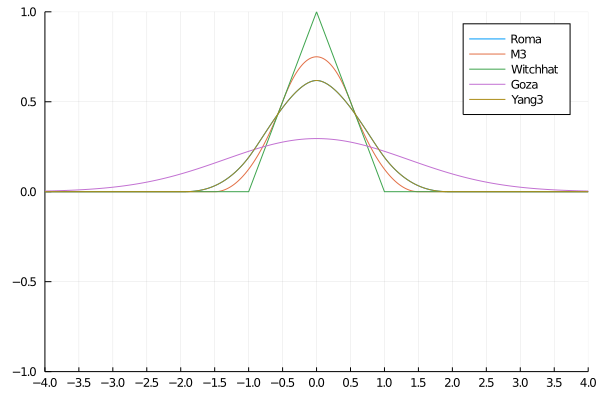

In [3]:
ddf = DDF();
x = range(-4,stop=4,length=401);
plt = plot(x,ddf.(x),label="Roma",ylim=(-1,1),xlim=(-4,4),xticks=-4:0.5:4,grid=:on)
ddf2 = DDF(ddftype=CartesianGrids.M3);
plot!(plt,x,ddf2.(x),label="M3")
ddf4 = DDF(ddftype=CartesianGrids.Witchhat);
plot!(plt,x,ddf4.(x),label="Witchhat")
ddf5 = DDF(ddftype=CartesianGrids.Goza);
plot!(plt,x,ddf5.(x),label="Goza")
ddf6 = DDF(ddftype=CartesianGrids.Yang3)
plot!(plt,x,ddf6.(x),label="Yang3")
plot(plt)

and here are the derivatives of these functions

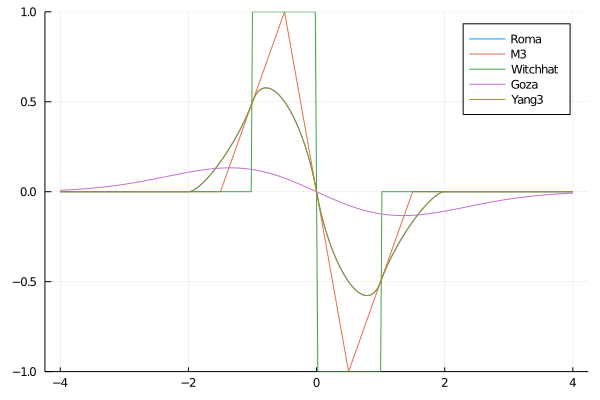

In [4]:
d_ddf = GradDDF(1);
x = range(-4,stop=4,length=401);
plt = plot(x,d_ddf.(x),label="Roma",ylim=(-1,1))
d_ddf2 = GradDDF(1,ddftype=CartesianGrids.M3);
plot!(plt,x,d_ddf2.(x),label="M3")
d_ddf4 = GradDDF(1,ddftype=CartesianGrids.Witchhat);
plot!(plt,x,d_ddf4.(x),label="Witchhat")
d_ddf5 = GradDDF(1,ddftype=CartesianGrids.Goza);
plot!(plt,x,d_ddf5.(x),label="Goza")
d_ddf6 = GradDDF(1,ddftype=CartesianGrids.Yang3);
plot!(plt,x,d_ddf6.(x),label="Yang3")

### Regularization and interpolation
In the following, we will demonstrate how to **regularize** point data to the grid, and how to **interpolate** grid data back to the points.

#### Set up a circle of points

In [3]:
n = 157;
θ = range(0,stop=2π,length=n+1);
R = 0.5
x = 1.0 .+ R*cos.(θ[1:n])
y = 1.0 .+ R*sin.(θ[1:n])
ds = 2π/n*R
X = VectorData(x,y);
f = ScalarData(X);

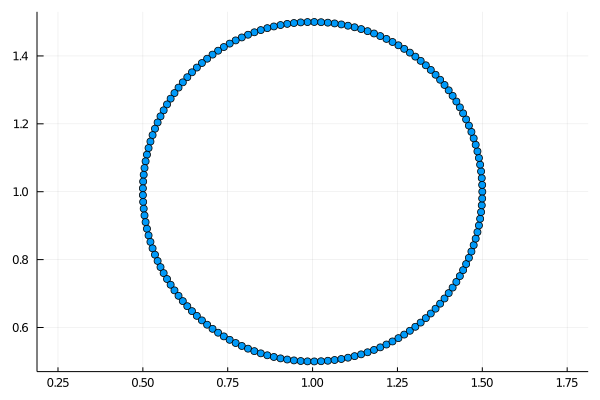

In [4]:
scatter(x,y,ratio=1,legend=false)

#### Set up the physical dimensions of the grid and create empty data

In [5]:
nx = 102; ny = 102
Lx = 2.0
dx = Lx/(nx-2)
q = Edges(Primal,(nx,ny))
w = Nodes(Dual,q)
w̃ = Nodes(Primal,w)
p = Edges(Dual,w)
nothing

#### Create a regularization operator with the point data
The default DDF kernel is `Yang3`. Here, we construct the regularization so that it weights the point data with the spacing between points `ds`.

In [6]:
H = Regularize(X,dx;weights=ds)

Regularization/interpolation operator with non-filtered interpolation
  DDF type CartesianGrids.Yang3
  157 points in grid with cell area 0.0004


and here is a regularized version of this operator.

In [7]:
H̃ = Regularize(X,dx;weights=ds,filter=true)

Regularization/interpolation operator with filtered interpolation
  DDF type CartesianGrids.Yang3
  157 points in grid with cell area 0.0004


#### Now set up some vector data on the points

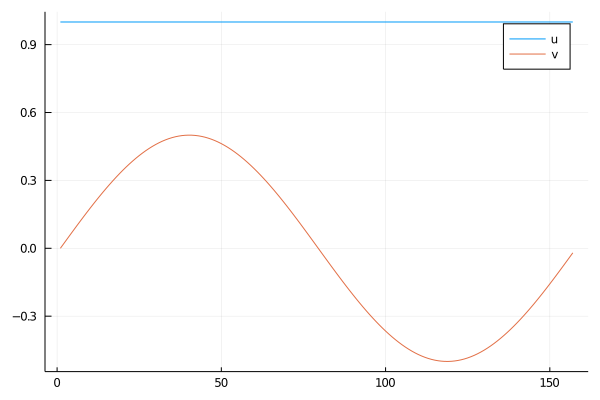

In [8]:
f = VectorData(X)
fill!(f.u,1.0)
f.v .= X.v.-1.0
plot(f.u,lab="u")
plot!(f.v,lab="v")

#### Regularize the data
The `H` operator we have constructed can work on many different combinations of point data and grid data types. It accepts the source data (the point data) in the second argument, and the target data (the grid data) in the first argument.

Here, we apply it to vector data on the points (`f`), and regularize it to primal edges on the grid (`q`).

In [11]:
@time H(q,f);

  0.001098 seconds (4.40 k allocations: 351.234 KiB)


We can also create a matrix representation of the regularization, and apply it. The advantage of this approach is that it precomputes the point-to-grid calculations, which can be expensive. This matrix operator is specific to the data types specified in the second and third arguments. Here, we construct a matrix operator from vector data to primal edge data.

In [12]:
@time Hmat = RegularizationMatrix(H,f,q);

  0.001070 seconds (5.46 k allocations: 1.177 MiB)


Now apply the matrix. Notice that it is a lot faster (after it has been run once to compile it):

In [14]:
@time q = Hmat*f;

  0.000145 seconds (65 allocations: 164.016 KiB)


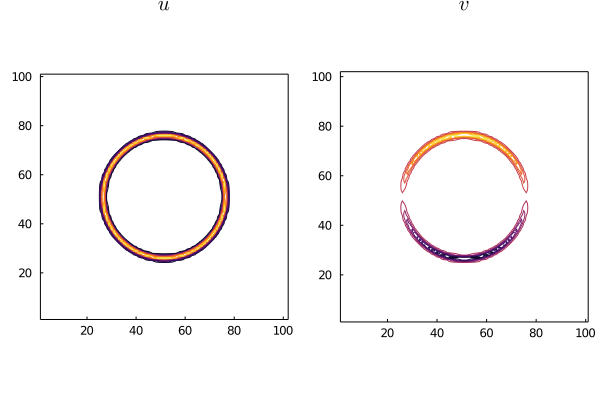

In [15]:
plot(q)

#### How has the data been scaled by this regularization operation?
Let us inspect the sums of the original point data (the x component, at least) and the regularized grid data. We scale the point data by the distance between points and the grid data by the cell area. The results are identical to within machine precision:

In [19]:
sum(f.u)*ds

3.141592653589793

In [20]:
sum(q.u)*dx*dx

3.1415926535897927

#### Now interpolate back to the points
Create a new vector point data structure (`f2`) to accept the interpolated data.

  0.221287 seconds (478.18 k allocations: 23.862 MiB, 6.26% gc time)


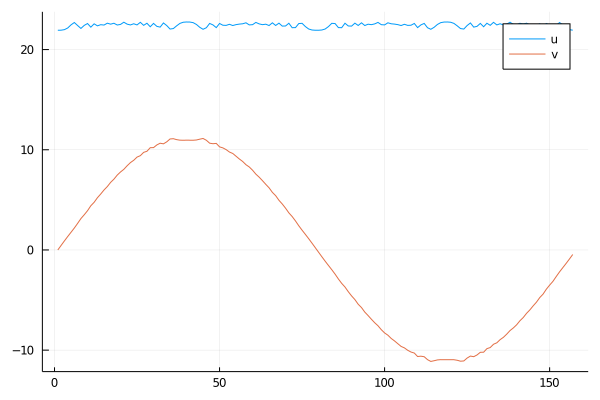

In [21]:
f2 = VectorData(X)
@time H(f2,q)
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

Note that the regularized data is not the same magnitude as the original data in `f`. These operations (regularization and interpolation) are **not** inverses of one another.

#### Like regularization, we can also create a matrix version of the interpolation
This is also a lot faster to apply than the original function-type operator

In [22]:
Emat = InterpolationMatrix(H,q,f2);

  0.033530 seconds (66.39 k allocations: 3.528 MiB)


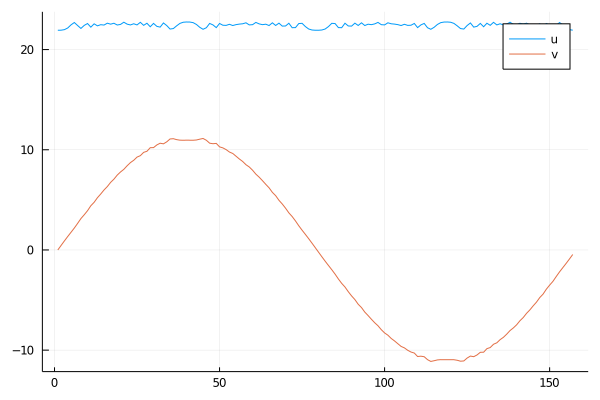

In [23]:
@time f2 = Emat*q
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### We can also create a symmetric version of the regularization and interpolation
This version does not weight the data in either operation. As a result, the regularized grid data is of similar magnitude to the original point data.

In [24]:
Hsymm = Regularize(X,dx,issymmetric=true)

Symmetric regularization/interpolation operator with non-filtered interpolation
  DDF type CartesianGrids.Yang3
  157 points in grid with cell area 0.0004


In [25]:
Hsymm(q,f);

This version simply preserves the sums of the data

In [26]:
sum(f.u)*ds

3.141592653589793

In [27]:
sum(q.u)*ds

3.1415926535897913

In other words, `q` is `dx^2/ds`

We can also create regularization and interpolation matrices all in one step with this kind: 

In [28]:
Hsymmmat, Esymmmat = RegularizationMatrix(Hsymm,f,q);

In [29]:
@time q = Hsymmmat*f
@time f2 = Esymmmat*q;

  0.000091 seconds (65 allocations: 164.016 KiB)
  0.000026 seconds (11 allocations: 3.062 KiB)


but the sum of the interpolated data is different. This re-scaling is different for each DDF type.

In [30]:
sum(f2.u)*ds

1.4088759894350864

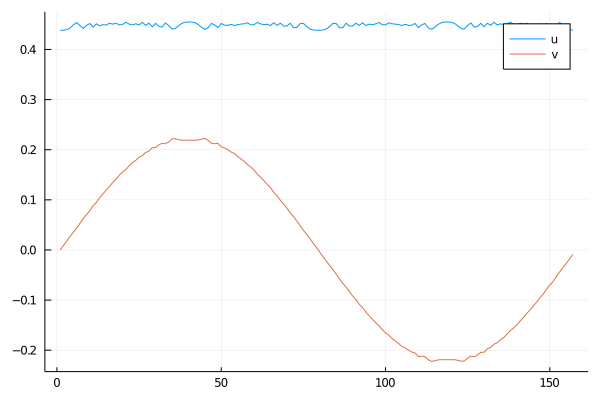

In [31]:
plot(f2.u,lab="u")
plot!(f2.v,lab="v")

#### Let's now explore a different DDF

In [32]:
H2 = Regularize(X,dx,weights=ds,ddftype=CartesianGrids.Roma)

Regularization/interpolation operator with non-filtered interpolation
  DDF type CartesianGrids.Roma
  157 points in grid with cell area 0.0004


In [33]:
H2mat = RegularizationMatrix(H2,f,q);

  0.000087 seconds (65 allocations: 164.016 KiB)


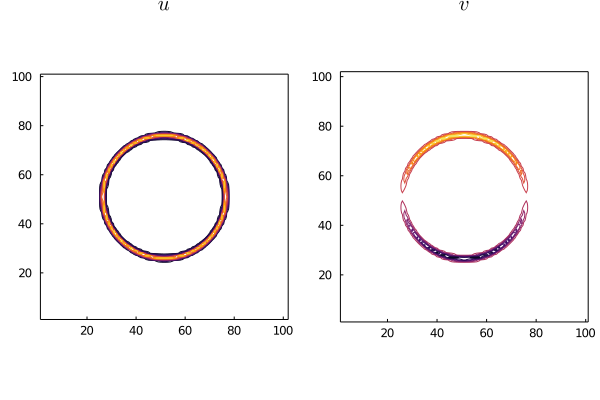

In [34]:
@time q = H2mat*f;
plot(q)

In [35]:
E2mat = InterpolationMatrix(H2,q,f2);

  0.000031 seconds (11 allocations: 3.062 KiB)


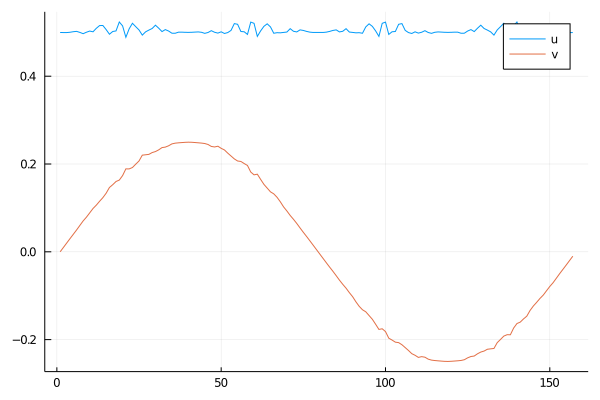

In [36]:
@time f2 = E2mat*q
plot(f2.u*dx*dx/ds,lab="u")
plot!(f2.v*dx*dx/ds,lab="v")

#### Regularize vector data onto dual edge field
We can also interpolate the vector-valued point data to other vector-valued grid types, such as dual edge data

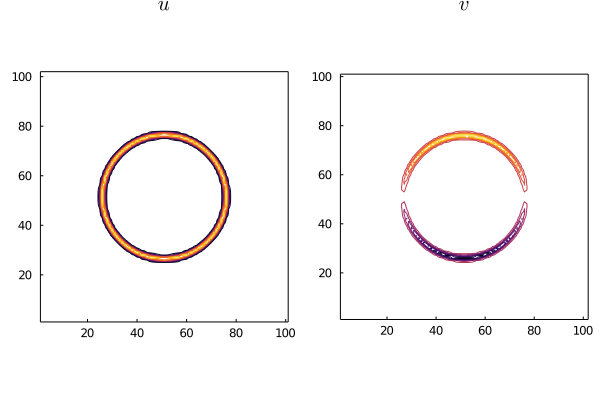

In [37]:
H(p,f)
plot(p)

#### Regularize vector data onto primal and dual nodal data
Another vector-valued grid data type is `NodePair`

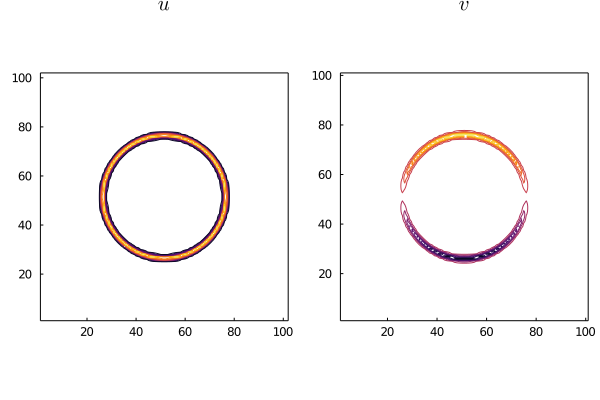

In [38]:
wpair = NodePair(Dual,Primal,(nx,ny))
H(wpair,f)
plot(wpair)

and generate a matrix that expresses this...

In [39]:
Hmat = RegularizationMatrix(H,f,wpair);

  0.273428 seconds (1.21 M allocations: 58.175 MiB)


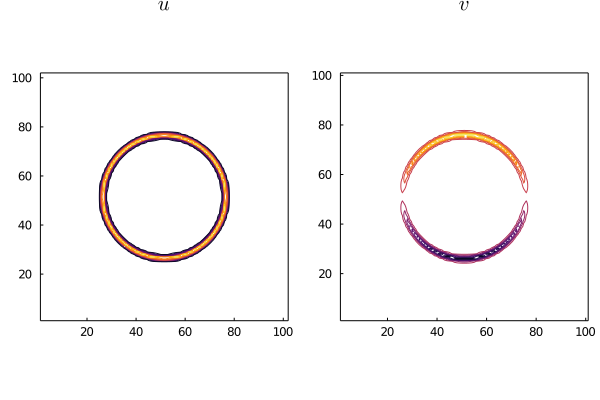

In [40]:
@time wpair .= Hmat*f
plot(wpair)

#### Tensor data
Now let us see how tensor-valued point data can be regularized to a tensor-valued grid (`EdgeGradient` type)

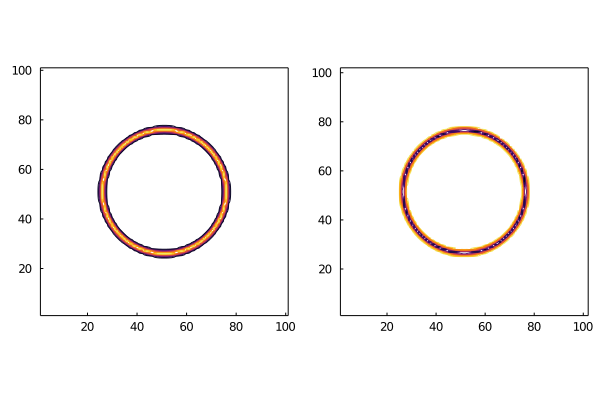

In [41]:
g = TensorData(X)
fill!(g.dudx,1.0)
fill!(g.dvdx,-2.0)
gradq = EdgeGradient(Primal,size(w))
H(gradq,g)
plot(plot(gradq.dudx),plot(gradq.dvdx))

and interpolation back to the points...

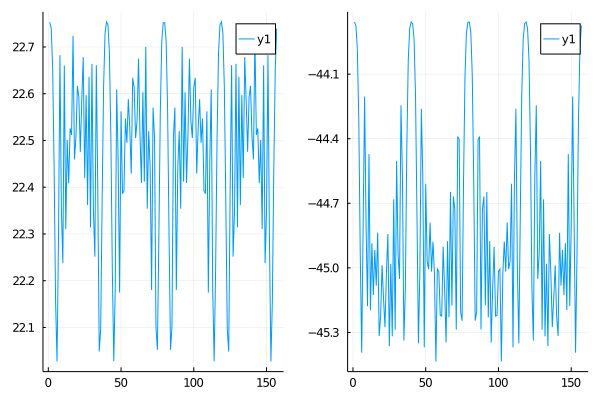

In [42]:
H(g,gradq)
plot(plot(g.dudx),plot(g.dvdx))

We can create matrix operators, like before

In [45]:
Hmat = RegularizationMatrix(H,g,gradq);

  0.000321 seconds (103 allocations: 326.656 KiB)


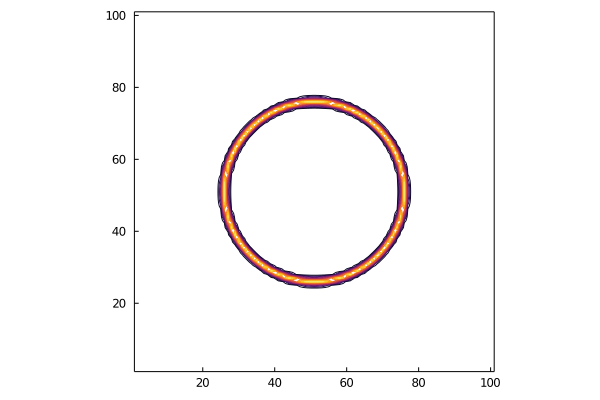

In [46]:
@time gradq .= Hmat*g
plot(gradq.dudx)

#### Now let us look at regularizing scalar data onto dual nodal field

  0.223515 seconds (556.64 k allocations: 26.780 MiB)


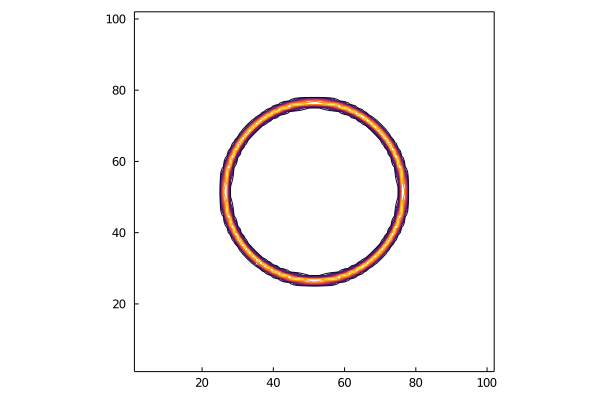

In [47]:
g = ScalarData(X)
fill!(g,1.0)
@time H(w,g)
plot(w)

#### Set up a matrix form of regularization

In [49]:
g = ScalarData(X)
w = Nodes(Dual,(nx,ny))
@time Hmat = RegularizationMatrix(H,g,w)
@time Emat = InterpolationMatrix(H,w,g);

  0.000582 seconds (2.71 k allocations: 589.312 KiB)
  0.000531 seconds (2.09 k allocations: 545.156 KiB)


  0.000123 seconds (8 allocations: 162.875 KiB)


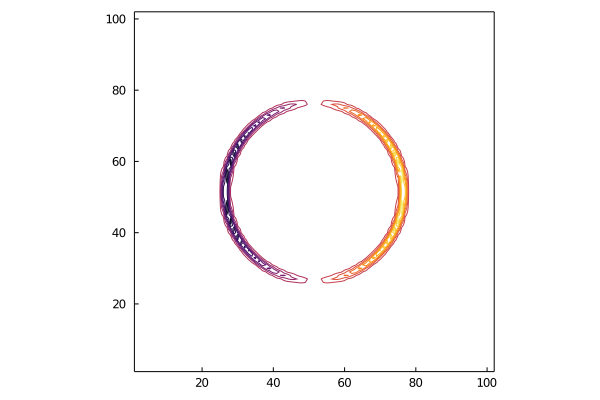

In [51]:
g = ScalarData(X)
g .= X.u .- 1.0
@time w = Hmat*g
plot(w)

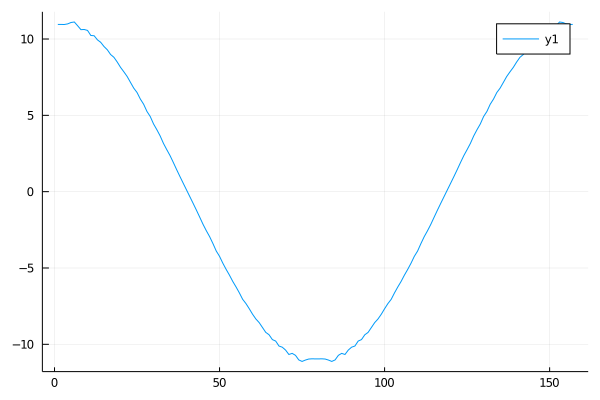

In [52]:
plot(Emat*w)

### Filtered interpolation
Earlier, we generated a filtered version of the operator. This is applied only to the interpolation step; it leaves the regularization as before. Let us see how this works.

First, let us generate some noisy point data

In [53]:
g = ScalarData(X)
g .= cos.(θ[1:n]) .+ 0.2*rand(n);

We regularize then interpolate with the filtered version.

  0.405276 seconds (967.68 k allocations: 47.809 MiB, 4.66% gc time)


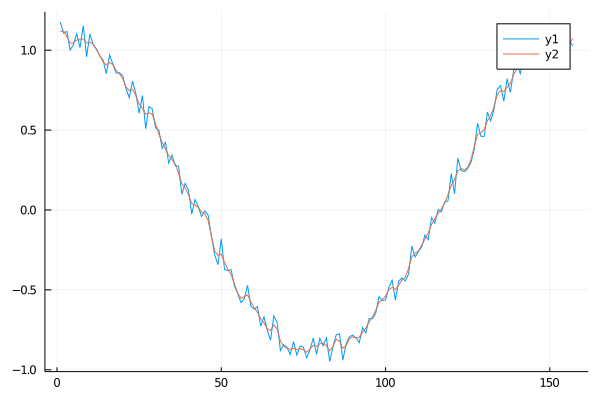

In [54]:
g2 = ScalarData(X)
@time H̃(g2,H̃(w,g))
plot(g)
plot!(g2)

In [55]:
Ẽmat = InterpolationMatrix(H̃,w,g);

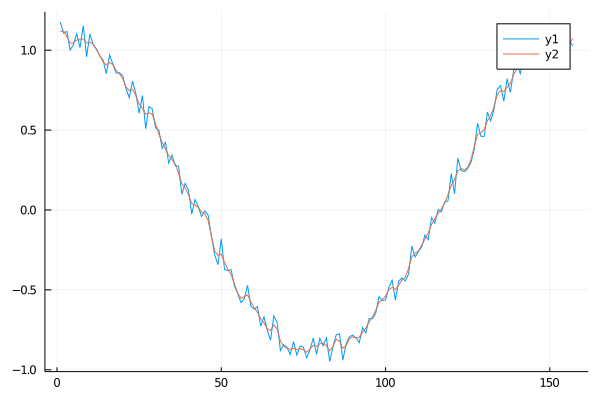

In [56]:
plot(g)
plot!(Ẽmat*(Hmat*g))

#### We can also construct a sparse representation of the composite of these operations

In [57]:
using SparseArrays
C = sparse(Ẽmat*Hmat)
nothing

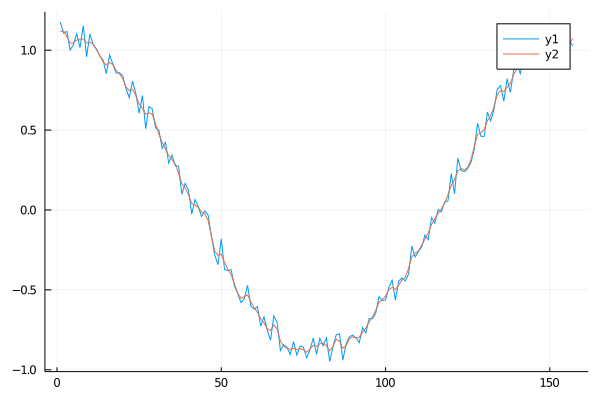

In [58]:
plot(g)
plot!(C*g)

### Derivative of the DDF

Now we will develop a gradient operator based on the DDF. First, let us generate some basic grid data to apply this to.

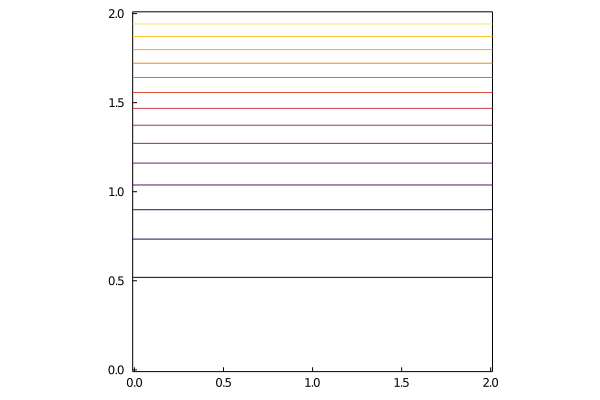

In [16]:
w = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w,dx=dx)
w .= transpose(yg).^2
plot(xg,yg,w)

We construct the operator with a derivative in a specified direction. Here, a gradient in the y (2) direction.

In [17]:
dHy = Regularize(X,dx,graddir=2)

Regularization/interpolation operator with non-filtered interpolation
  DDF type CartesianGrids.Yang3
  157 points in grid with cell area 0.0004


In [18]:
f = ScalarData(X);

In [19]:
dHy(f,w);

Note that interpolation does not use any weights. So the result must be explicitly divided by the grid spacing. The result is the negative of the gradient.

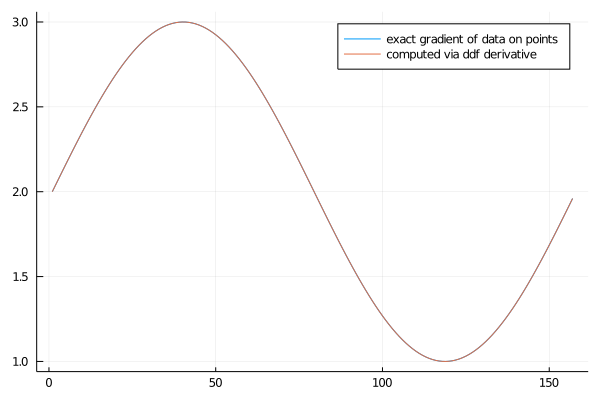

In [20]:
plot(2*X.v,lab="exact gradient of data on points")
plot!(-f/dx,lab="computed via ddf derivative")

As usual, we can generate matrix versions of these operations

In [21]:
dHymat = RegularizationMatrix(dHy,f,w);
dEymat = InterpolationMatrix(dHy,w,f);

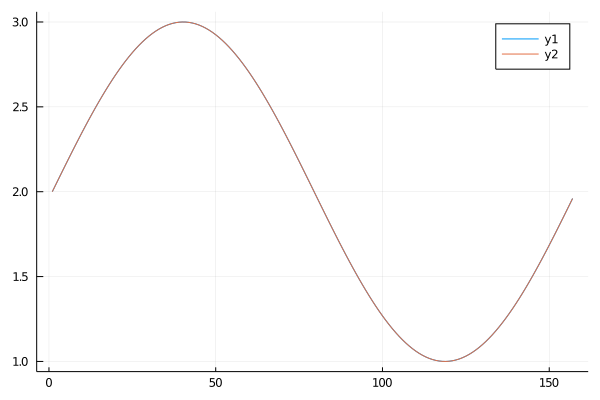

In [22]:
plot(2*X.v)
plot!(-(dEymat*w)/dx)

In [23]:
w2 = Nodes(Dual,w)
f .= X.v
w2 .= dHymat*f

Nodes{Dual,102,102,Float64,Array{Float64,2}} data
Printing in grid orientation (lower left is (1,1))
102×102 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0 

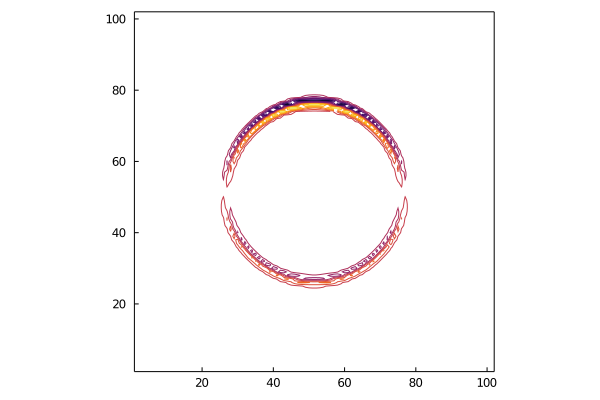

In [24]:
plot(w2)